In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import shap
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("assets/01-machine_performance_random_1000_dataset_V2.csv")

data

,Machine,Temps ouverture (heures),Arret planifie (heures),Duree de panne (heures),Ecart de cadence (heures),Nombre de piece bonne,Cadence de production (piees/minute)
0,M1,15,1.156961,1.099763,0.662674,757,60
1,M2,15,1.211035,0.855025,0.317592,695,51
2,M3,15,2.136547,1.071865,0.429608,872,64
3,M4,16,1.359729,1.190878,0.409812,653,53
4,M1,16,1.540807,0.630224,0.180200,648,51
...,...,...,...,...,...,...,...
995,M4,15,1.923029,1.112017,0.341187,857,54
996,M1,15,1.115517,0.727697,0.324885,695,50
997,M2,15,2.235595,1.189442,0.235546,876,59
998,M3,15,1.090204,1.094100,0.649350,681,57


In [3]:
df = data.copy()
df.dropna(inplace=True)

# Partie 1 : Analyse industrielle et modélisation
## 1. Calcul du temps de fonctionnement
$Temps\ de\ fonctionnement = Temps\ d’ouverture - Arrêt\ planifié - Durée\ de\ panne$

In [4]:
df["Temps de fonctionnement"] = df["Temps ouverture (heures)"] - df["Arret planifie (heures)"] - df["Duree de panne (heures)"]

## 2. Calcul du temps requis
$Temps\ requis = Temps\ de\ fonctionnement - Ecart\ de\ cadence$

In [5]:
df["Temps requis"] = df["Temps de fonctionnement"] - df["Ecart de cadence (heures)"]

## 3. Calcul du temps net
$Temps\ net = Temps\ requis$

In [6]:
df["Temps net"] = df["Temps requis"]

## 4. Calcul du temps utile
$Temps\ utile = \frac{Nombre\ de\ piece\ bonne}{Cadence\ de\ production \times 60}$

In [7]:
df["Temps utile"] = df["Nombre de piece bonne"] / (df["Cadence de production (piees/minute)"] * 60)

## 5. Calcul de l&#39;efficacité globale des équipements (TRS)
$TRS = \frac{Temps\ utile}{Temps\ de\ fonctionnement} \times 100$

In [8]:
df["TRS"] = (df["Temps utile"] / df["Temps de fonctionnement"]) * 100 

In [9]:
df

,Machine,Temps ouverture (heures),Arret planifie (heures),Duree de panne (heures),Ecart de cadence (heures),Nombre de piece bonne,Cadence de production (piees/minute),Temps de fonctionnement,Temps requis,Temps net,Temps utile,TRS
0,M1,15,1.156961,1.099763,0.662674,757,60,12.743276,12.080601,12.080601,0.210278,1.650108
1,M2,15,1.211035,0.855025,0.317592,695,51,12.933940,12.616348,12.616348,0.227124,1.756032
2,M3,15,2.136547,1.071865,0.429608,872,64,11.791588,11.361981,11.361981,0.227083,1.925808
3,M4,16,1.359729,1.190878,0.409812,653,53,13.449393,13.039580,13.039580,0.205346,1.526804
4,M1,16,1.540807,0.630224,0.180200,648,51,13.828969,13.648769,13.648769,0.211765,1.531312
...,...,...,...,...,...,...,...,...,...,...,...,...
995,M4,15,1.923029,1.112017,0.341187,857,54,11.964955,11.623768,11.623768,0.264506,2.210674
996,M1,15,1.115517,0.727697,0.324885,695,50,13.156786,12.831901,12.831901,0.231667,1.760815
997,M2,15,2.235595,1.189442,0.235546,876,59,11.574963,11.339417,11.339417,0.247458,2.137870
998,M3,15,1.090204,1.094100,0.649350,681,57,12.815695,12.166345,12.166345,0.199123,1.553742


## 6. Identifiez la machine ayant le meilleur TRS.

In [10]:
df[df["TRS"] == df["TRS"].max()]

,Machine,Temps ouverture (heures),Arret planifie (heures),Duree de panne (heures),Ecart de cadence (heures),Nombre de piece bonne,Cadence de production (piees/minute),Temps de fonctionnement,Temps requis,Temps net,Temps utile,TRS
882,M3,15,1.91493,1.416835,0.615881,856,50,11.668235,11.052354,11.052354,0.285333,2.445386


# Partie 2 : Intelligence Artificielle avec application d’un ANN
## Étape 1 : Préparation des données

In [11]:
df.drop(columns=["Temps ouverture (heures)", "Arret planifie (heures)", "Duree de panne (heures)", "Ecart de cadence (heures)", "Nombre de piece bonne", "Cadence de production (piees/minute)"], inplace=True, axis=1)

df

,Machine,Temps de fonctionnement,Temps requis,Temps net,Temps utile,TRS
0,M1,12.743276,12.080601,12.080601,0.210278,1.650108
1,M2,12.933940,12.616348,12.616348,0.227124,1.756032
2,M3,11.791588,11.361981,11.361981,0.227083,1.925808
3,M4,13.449393,13.039580,13.039580,0.205346,1.526804
4,M1,13.828969,13.648769,13.648769,0.211765,1.531312
...,...,...,...,...,...,...
995,M4,11.964955,11.623768,11.623768,0.264506,2.210674
996,M1,13.156786,12.831901,12.831901,0.231667,1.760815
997,M2,11.574963,11.339417,11.339417,0.247458,2.137870
998,M3,12.815695,12.166345,12.166345,0.199123,1.553742


In [12]:
scaler = MinMaxScaler()

df["Temps de fonctionnement"] = scaler.fit_transform(df[["Temps de fonctionnement"]])
df["Temps requis"] = scaler.fit_transform(df[["Temps requis"]])
df["Temps net"] = scaler.fit_transform(df[["Temps net"]])
df["Temps utile"] = scaler.fit_transform(df[["Temps utile"]])
df["TRS"] = scaler.fit_transform(df[["TRS"]])

df

,Machine,Temps de fonctionnement,Temps requis,Temps net,Temps utile,TRS
0,M1,0.384689,0.317476,0.317476,0.392376,0.440082
1,M2,0.429390,0.434432,0.434432,0.515914,0.514659
2,M3,0.161564,0.160598,0.160598,0.515614,0.634190
3,M4,0.550239,0.526826,0.526826,0.356210,0.353270
4,M1,0.639231,0.659814,0.659814,0.403280,0.356444
...,...,...,...,...,...,...
995,M4,0.202210,0.217747,0.217747,0.790043,0.834751
996,M1,0.481637,0.481488,0.481488,0.549225,0.518026
997,M2,0.110776,0.155672,0.155672,0.665023,0.783493
998,M3,0.401668,0.336194,0.336194,0.310575,0.372235


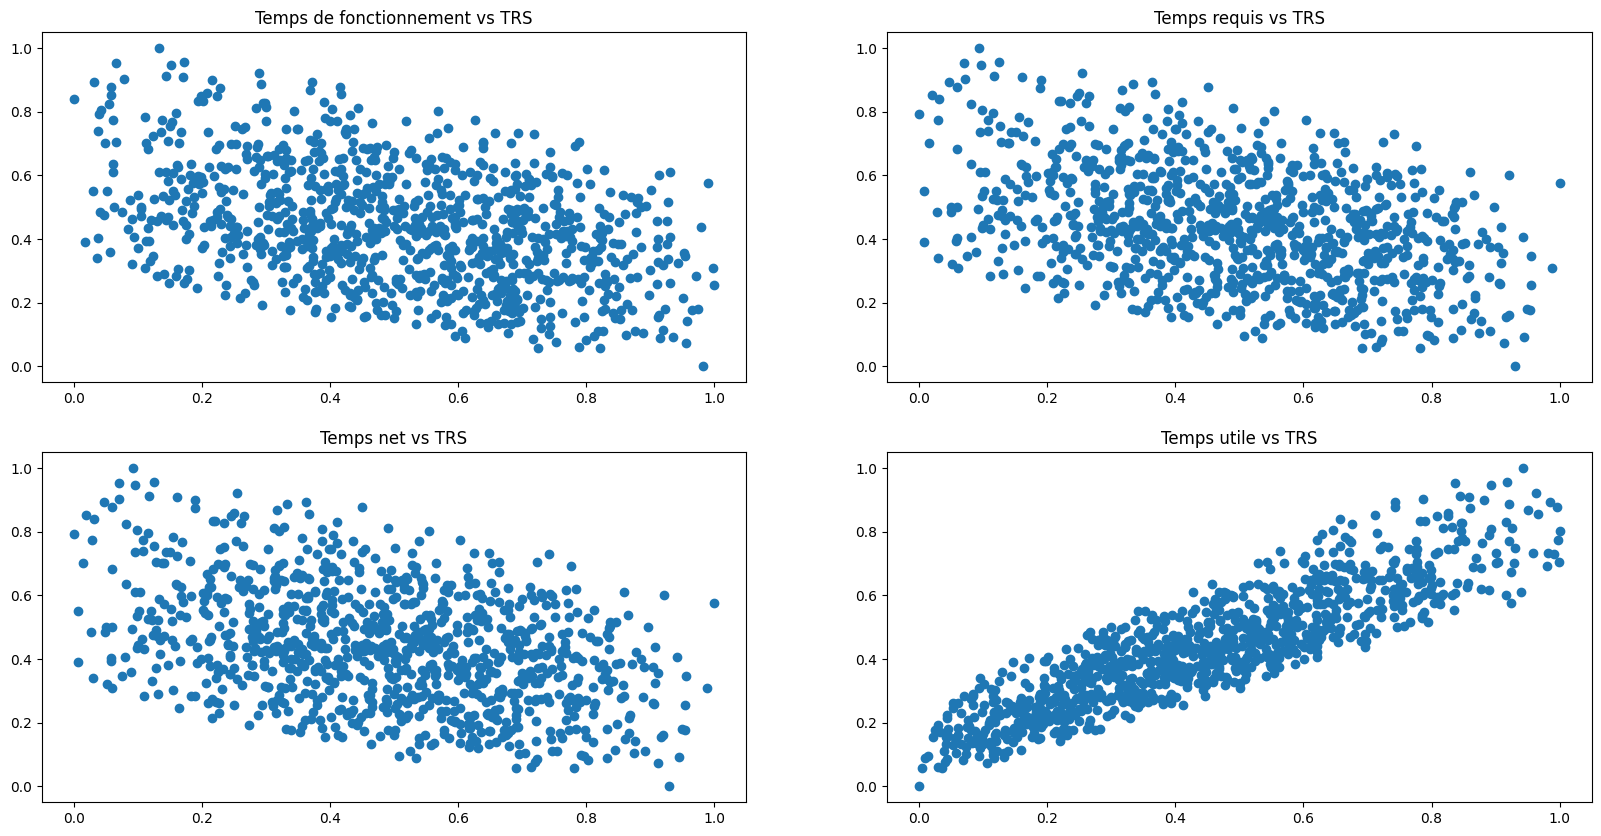

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].scatter(df["Temps de fonctionnement"], df["TRS"])
axs[0, 0].set_title("Temps de fonctionnement vs TRS")

axs[0, 1].scatter(df["Temps requis"], df["TRS"])
axs[0, 1].set_title("Temps requis vs TRS")

axs[1, 0].scatter(df["Temps net"], df["TRS"])
axs[1, 0].set_title("Temps net vs TRS")

axs[1, 1].scatter(df["Temps utile"], df["TRS"])
axs[1, 1].set_title("Temps utile vs TRS")

plt.show()

## Étape 2 : Application du modèle ANN
### Regression

In [14]:
class REG_ANN(nn.Module):
    def __init__(self, input_size, hidden_size_1 = 16, hidden_size_2 = 16, hidden_2_output = 16):
        super(REG_ANN, self).__init__()
        self.input = nn.Linear(input_size, hidden_size_1)
        self.hidden_1 = nn.Linear(hidden_size_1, hidden_size_2)
        self.hidden_2 = nn.Linear(hidden_size_2, hidden_2_output)
        self.output = nn.Linear(hidden_2_output, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = self.output(x)
        return x
    
def train_and_evaluate(x_train, x_test, y_train, y_test, lr, epochs, hidden_size_1 = 16, hidden_size_2 = 16, hidden_2_output = 16):
    model = REG_ANN(x_train.shape[1], hidden_size_1, hidden_size_2, hidden_2_output)
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        pred = model(x_train)
        loss = loss_func(pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1} - Loss: {loss.item()}")
        train_losses.append(loss.item())
        with torch.no_grad():
            model.eval()
            test_loss = loss_func(model(x_test), y_test)
            test_losses.append(test_loss.item())

    predictions = model(x_test)
    mse = loss_func(predictions, y_test).item()

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {nn.L1Loss()(predictions, y_test).item()}")

    return model, predictions.detach(), mse, train_losses, test_losses

In [15]:
x = df.drop(columns=["Machine", "TRS"]).values
y_reg = df["TRS"].values

x_train, x_test, y_reg_train, y_reg_test = train_test_split(x, y_reg, test_size=0.2, random_state=42)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_reg_train = torch.tensor(y_reg_train, dtype=torch.float32).view(-1, 1)
y_reg_test = torch.tensor(y_reg_test, dtype=torch.float32).view(-1, 1)

In [16]:
reg_model, predictions_ann_reg, mse_ann, train_losses, test_losses = train_and_evaluate(x_train, x_test, y_reg_train, y_reg_test, 0.001, 1000, 128, 128, 64)

Epoch 10 - Loss: 0.033032823354005814
Epoch 20 - Loss: 0.021703321486711502
Epoch 30 - Loss: 0.010720797814428806
Epoch 40 - Loss: 0.002745336387306452
Epoch 50 - Loss: 0.0011411352315917611
Epoch 60 - Loss: 0.00071005302015692
Epoch 70 - Loss: 0.00042175178532488644
Epoch 80 - Loss: 0.00029909322620369494
Epoch 90 - Loss: 0.0002049979957519099
Epoch 100 - Loss: 0.00014239632582757622
Epoch 110 - Loss: 9.590510308044031e-05
Epoch 120 - Loss: 6.948115333216265e-05
Epoch 130 - Loss: 5.329877603799105e-05
Epoch 140 - Loss: 4.466637983568944e-05
Epoch 150 - Loss: 3.946331707993522e-05
Epoch 160 - Loss: 3.5703680623555556e-05
Epoch 170 - Loss: 3.264940460212529e-05
Epoch 180 - Loss: 2.995422801177483e-05
Epoch 190 - Loss: 2.751491774688475e-05
Epoch 200 - Loss: 2.521544047340285e-05
Epoch 210 - Loss: 2.319505983905401e-05
Epoch 220 - Loss: 2.14995707210619e-05
Epoch 230 - Loss: 1.9977875126642175e-05
Epoch 240 - Loss: 1.856590824900195e-05
Epoch 250 - Loss: 1.7233189282706007e-05
Epoch 260 

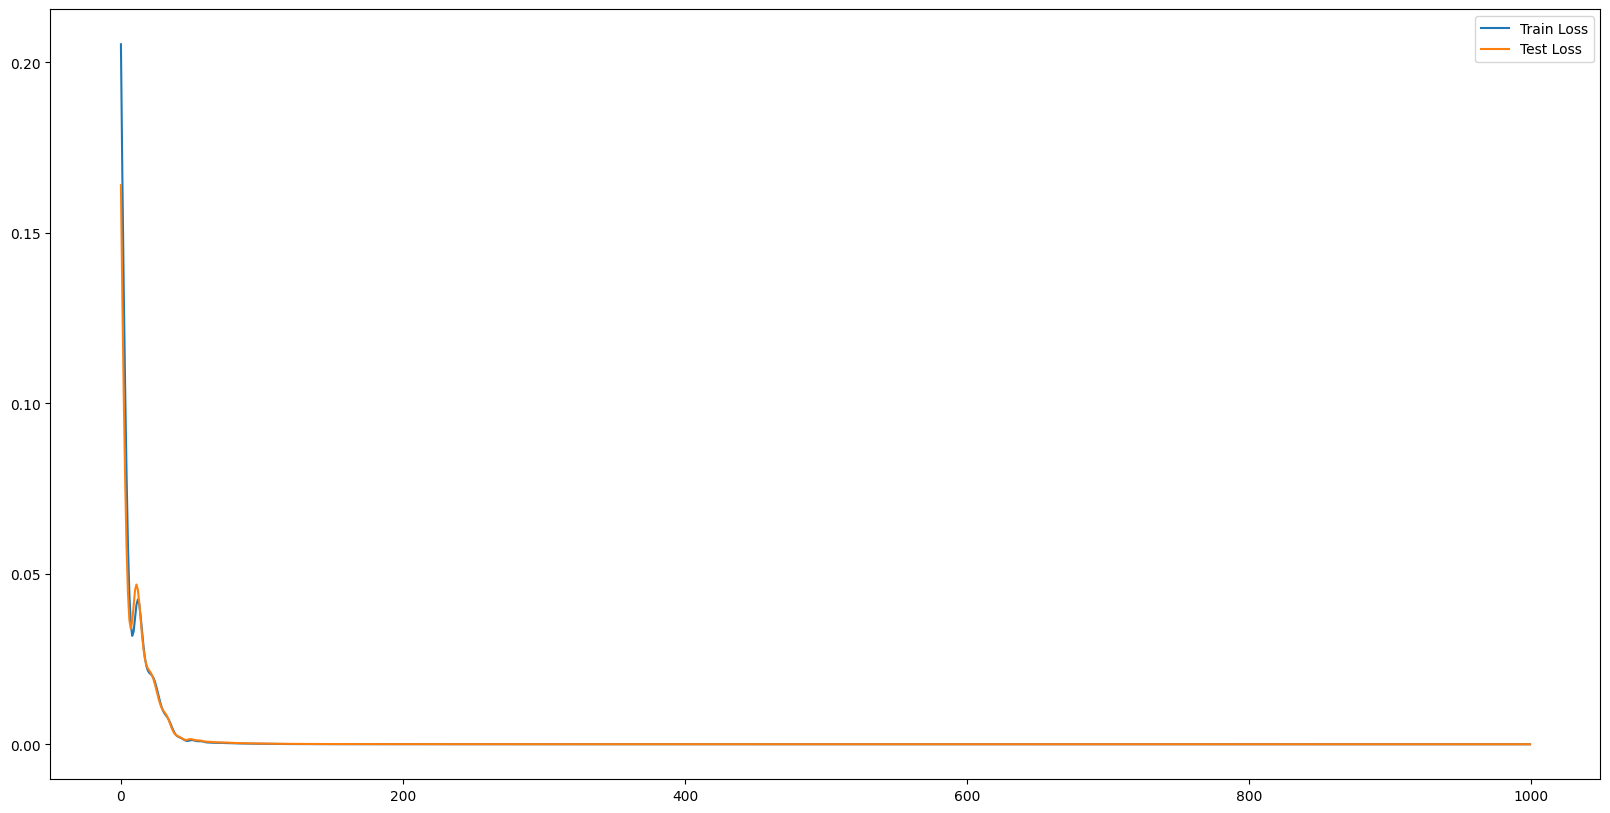

In [17]:
fig = plt.figure(figsize=(20, 10))

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

### Labeling

In [18]:
def label_perfomance(row):
    if row["TRS"] < 0.2:
        return "Tres faible"
    elif row["TRS"] < 0.4:
        return "Faible"
    elif row["TRS"] < 0.6:
        return "Moyen"
    elif row["TRS"] < 0.8:
        return "Bon"
    else:
        return "Tres bon"

In [19]:
df["Performance"] = df.apply(label_perfomance, axis=1)

df

,Machine,Temps de fonctionnement,Temps requis,Temps net,Temps utile,TRS,Performance
0,M1,0.384689,0.317476,0.317476,0.392376,0.440082,Moyen
1,M2,0.429390,0.434432,0.434432,0.515914,0.514659,Moyen
2,M3,0.161564,0.160598,0.160598,0.515614,0.634190,Bon
3,M4,0.550239,0.526826,0.526826,0.356210,0.353270,Faible
4,M1,0.639231,0.659814,0.659814,0.403280,0.356444,Faible
...,...,...,...,...,...,...,...
995,M4,0.202210,0.217747,0.217747,0.790043,0.834751,Tres bon
996,M1,0.481637,0.481488,0.481488,0.549225,0.518026,Moyen
997,M2,0.110776,0.155672,0.155672,0.665023,0.783493,Bon
998,M3,0.401668,0.336194,0.336194,0.310575,0.372235,Faible


### Classification

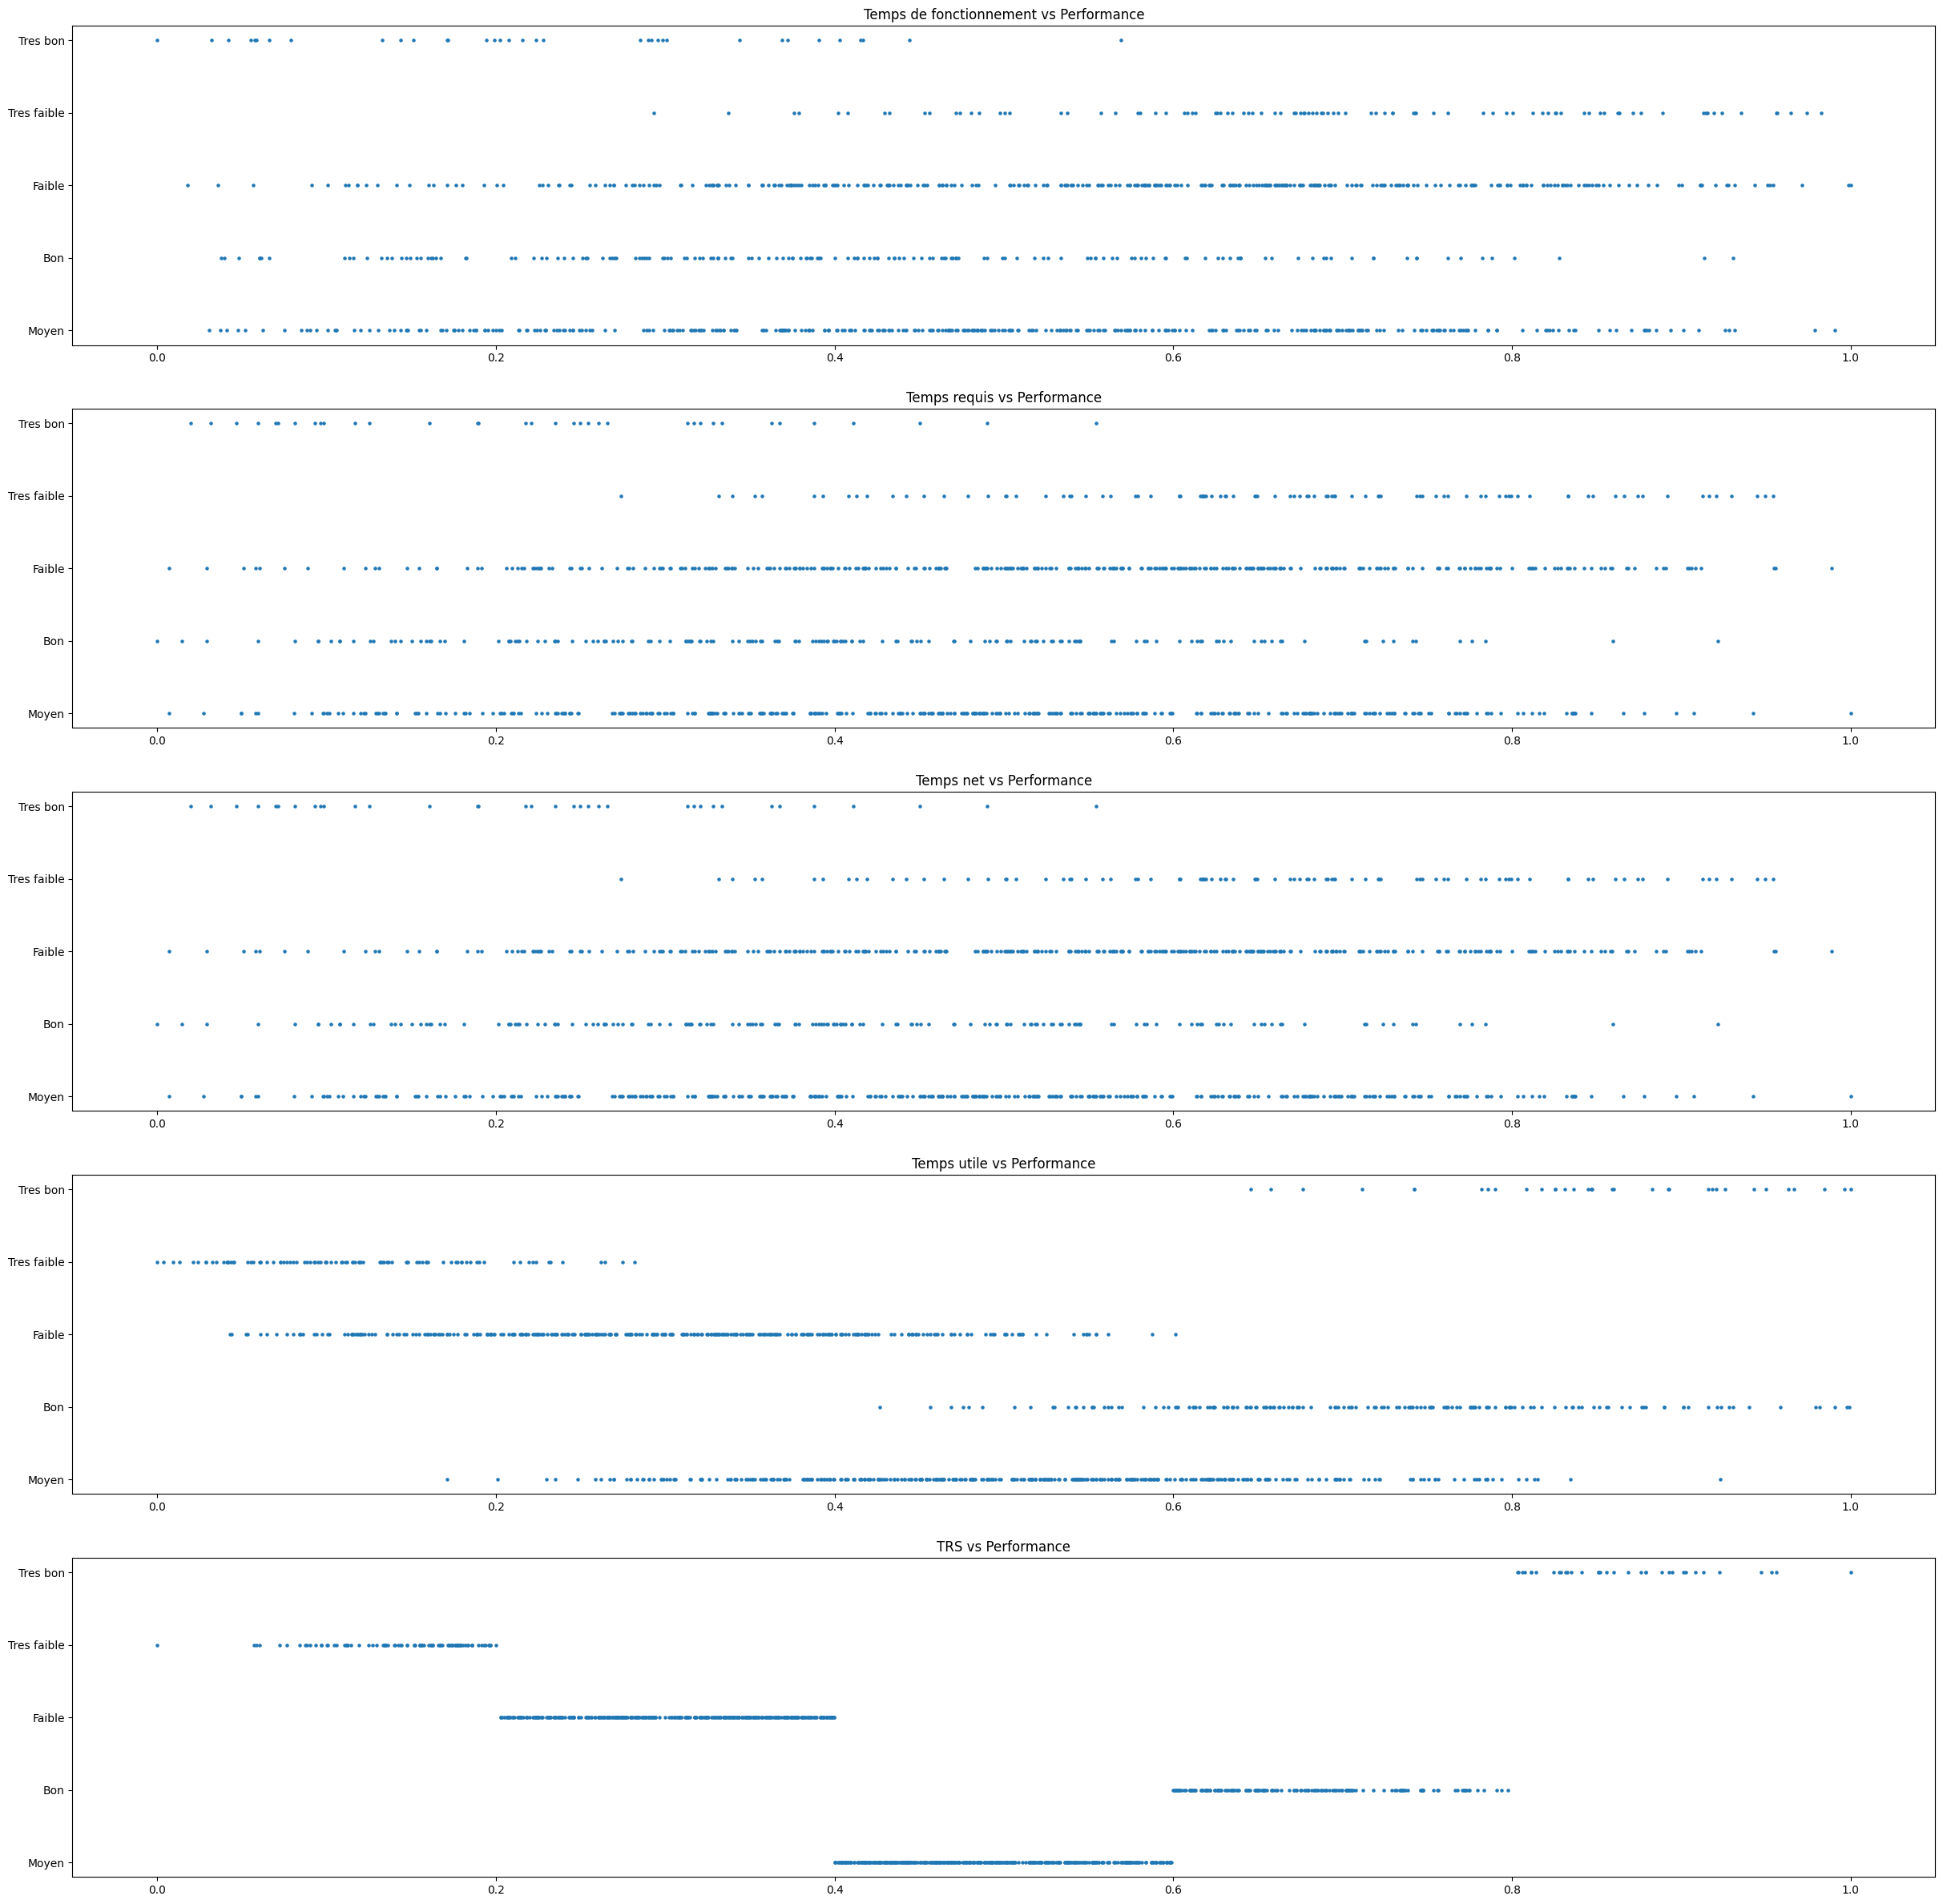

In [20]:
fig, axs = plt.subplots(5, 1, figsize=(30, 30))

axs[0].scatter(df["Temps de fonctionnement"], df["Performance"], s=5)
axs[0].set_title("Temps de fonctionnement vs Performance")

axs[1].scatter(df["Temps requis"], df["Performance"], s=5)
axs[1].set_title("Temps requis vs Performance")

axs[2].scatter(df["Temps net"], df["Performance"], s=5)
axs[2].set_title("Temps net vs Performance")

axs[3].scatter(df["Temps utile"], df["Performance"], s=5)
axs[3].set_title("Temps utile vs Performance")

axs[4].scatter(df["TRS"], df["Performance"], s=5)
axs[4].set_title("TRS vs Performance")

plt.show()

In [21]:
y_clf = torch.tensor(df["Performance"].apply(lambda x: 0 if x == "Tres faible" else 1 if x == "Faible" else 2 if x == "Moyen" else 3 if x == "Bon" else 4).values, dtype=torch.int64)

x_train, x_test, y_clf_train, y_clf_test = train_test_split(x, y_clf, test_size=0.2, random_state=42)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_clf_train = torch.tensor(y_clf_train, dtype=torch.int64)
y_clf_test = torch.tensor(y_clf_test, dtype=torch.int64)

/tmp/ipykernel_4117/1689440438.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_clf_train = torch.tensor(y_clf_train, dtype=torch.int64)
/tmp/ipykernel_4117/1689440438.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_clf_test = torch.tensor(y_clf_test, dtype=torch.int64)


In [22]:
class CLF_ANN(nn.Module):
    def __init__(self, input_size = 4, hidden_size_1 = 16, hidden_size_2 = 16, hidden_2_output = 16, output_size = 5):
        super().__init__()
        self.input = nn.Linear(input_size, hidden_size_1)
        self.hidden_1 = nn.Linear(hidden_size_1, hidden_size_2)
        self.hidden_2 = nn.Linear(hidden_size_2, hidden_2_output)
        self.output = nn.Linear(hidden_2_output, output_size)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = self.output(x)
        return x
    
def train_and_evaluate(x_train, x_test, y_train, y_test, lr, n_epochs, hidden_size_1 = 16, hidden_size_2 = 16, hidden_2_output = 16, output_size = 5):
    model = CLF_ANN(x_train.shape[1], hidden_size_1, hidden_size_2, hidden_2_output, output_size)
    # BCEWithLogitsLoss() implements the Sigmoid function for us
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []

    for curr_epoch in range(n_epochs):
        model.train()
        pred = model(x_train)
        loss = criterion(pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (curr_epoch + 1) % 10 == 0:
            print(f"Epoch {curr_epoch + 1} - Loss: {loss.item()}")
        train_losses.append(loss.item())
        with torch.no_grad():
            model.eval()
            test_loss = criterion(model(x_test), y_test)
            test_losses.append(test_loss.item())
        
    prediction_probas = model(x_test)
    __, predictions = torch.max(prediction_probas, 1)
    acc = accuracy_score(y_clf_test, predictions)
    print(f"Accuracy: {acc}")

    return model, predictions.detach(), acc, train_losses, test_losses

In [23]:
clf_model, predictions_ann_clf, acc_ann, train_losses, test_losses = train_and_evaluate(x_train, x_test, y_clf_train, y_clf_test, 0.001, 500, 1024, 1024, 512, 5)

Epoch 10 - Loss: 0.9355869293212891
Epoch 20 - Loss: 0.40613096952438354
Epoch 30 - Loss: 0.18257299065589905
Epoch 40 - Loss: 0.11589030921459198
Epoch 50 - Loss: 0.08670826256275177
Epoch 60 - Loss: 0.07386483252048492
Epoch 70 - Loss: 0.06595159322023392
Epoch 80 - Loss: 0.058476876467466354
Epoch 90 - Loss: 0.05396883189678192
Epoch 100 - Loss: 0.04891415685415268
Epoch 110 - Loss: 0.044827863574028015
Epoch 120 - Loss: 0.03803424909710884
Epoch 130 - Loss: 0.0341128334403038
Epoch 140 - Loss: 0.03670792654156685
Epoch 150 - Loss: 0.031881242990493774
Epoch 160 - Loss: 0.033713772892951965
Epoch 170 - Loss: 0.028175773099064827
Epoch 180 - Loss: 0.026153791695833206
Epoch 190 - Loss: 0.024396011605858803
Epoch 200 - Loss: 0.030918385833501816
Epoch 210 - Loss: 0.03096737712621689
Epoch 220 - Loss: 0.02849734015762806
Epoch 230 - Loss: 0.023771600797772408
Epoch 240 - Loss: 0.023040158674120903
Epoch 250 - Loss: 0.018880756571888924
Epoch 260 - Loss: 0.032677389681339264
Epoch 270 -

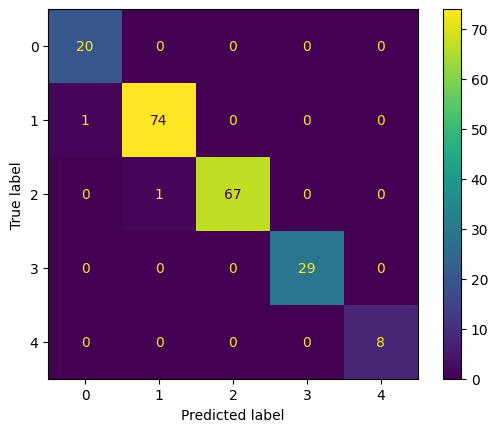

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_clf_test, predictions_ann_clf))

disp.plot()
plt.show()

## Étape 3 : Analyse de la meilleure machine

In [25]:
print(np.argmax(predictions_ann_reg.numpy()))

30


In [26]:
print(np.argmax(y_reg_test.numpy()))

30


Notre model ANN a prédit que la machine 30 est la meilleure machine, ce qui est en accord avec les données originales.

In [27]:
all_data_reg = reg_model(torch.tensor(x, dtype=torch.float32))

print(f"Mean Squared Error: {nn.MSELoss()(all_data_reg, torch.tensor(y_reg, dtype=torch.float32)).item()}")
print(f"Mean Absolute Error: {nn.L1Loss()(all_data_reg, torch.tensor(y_reg, dtype=torch.float32)).item()}")

Mean Squared Error: 0.06611339002847672
Mean Absolute Error: 0.20623283088207245


/home/lonewolf/projects/dl-tl-labs/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lonewolf/projects/dl-tl-labs/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [28]:
predictions_probas = clf_model(torch.tensor(x, dtype=torch.float32))
__, predictions = torch.max(predictions_probas, 1)

print(f"Accuracy: {accuracy_score(y_clf, predictions)}")

Accuracy: 0.998


In [29]:
comparison_df = pd.DataFrame({
    "Machine": df["Machine"],
    "Predicted TRS": all_data_reg.detach().numpy().flatten(),
    "Actual TRS": y_reg.flatten(),
    "Predicted Performance": predictions.detach().numpy(),
    "Actual Performance": y_clf.detach().numpy()
})

comparison_df

,Machine,Predicted TRS,Actual TRS,Predicted Performance,Actual Performance
0,M1,0.439277,0.440082,2,2
1,M2,0.514247,0.514659,2,2
2,M3,0.631955,0.634190,3,3
3,M4,0.353759,0.353270,1,1
4,M1,0.360454,0.356444,1,1
...,...,...,...,...,...
995,M4,0.834123,0.834751,4,4
996,M1,0.519286,0.518026,2,2
997,M2,0.783260,0.783493,3,3
998,M3,0.373592,0.372235,1,1


In [30]:
comparison_df.groupby('Machine', as_index=False).mean()

,Machine,Predicted TRS,Actual TRS,Predicted Performance,Actual Performance
0,M1,0.449546,0.449439,1.788,1.788
1,M2,0.419375,0.419278,1.584,1.584
2,M3,0.445372,0.445477,1.728,1.732
3,M4,0.439279,0.439289,1.704,1.708


Nos modeles preditent que la machine M1 a la meilleure performance, ce est en accord avec les données originales.

## Étape 4 : Analyse des composantes pénalisantes

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

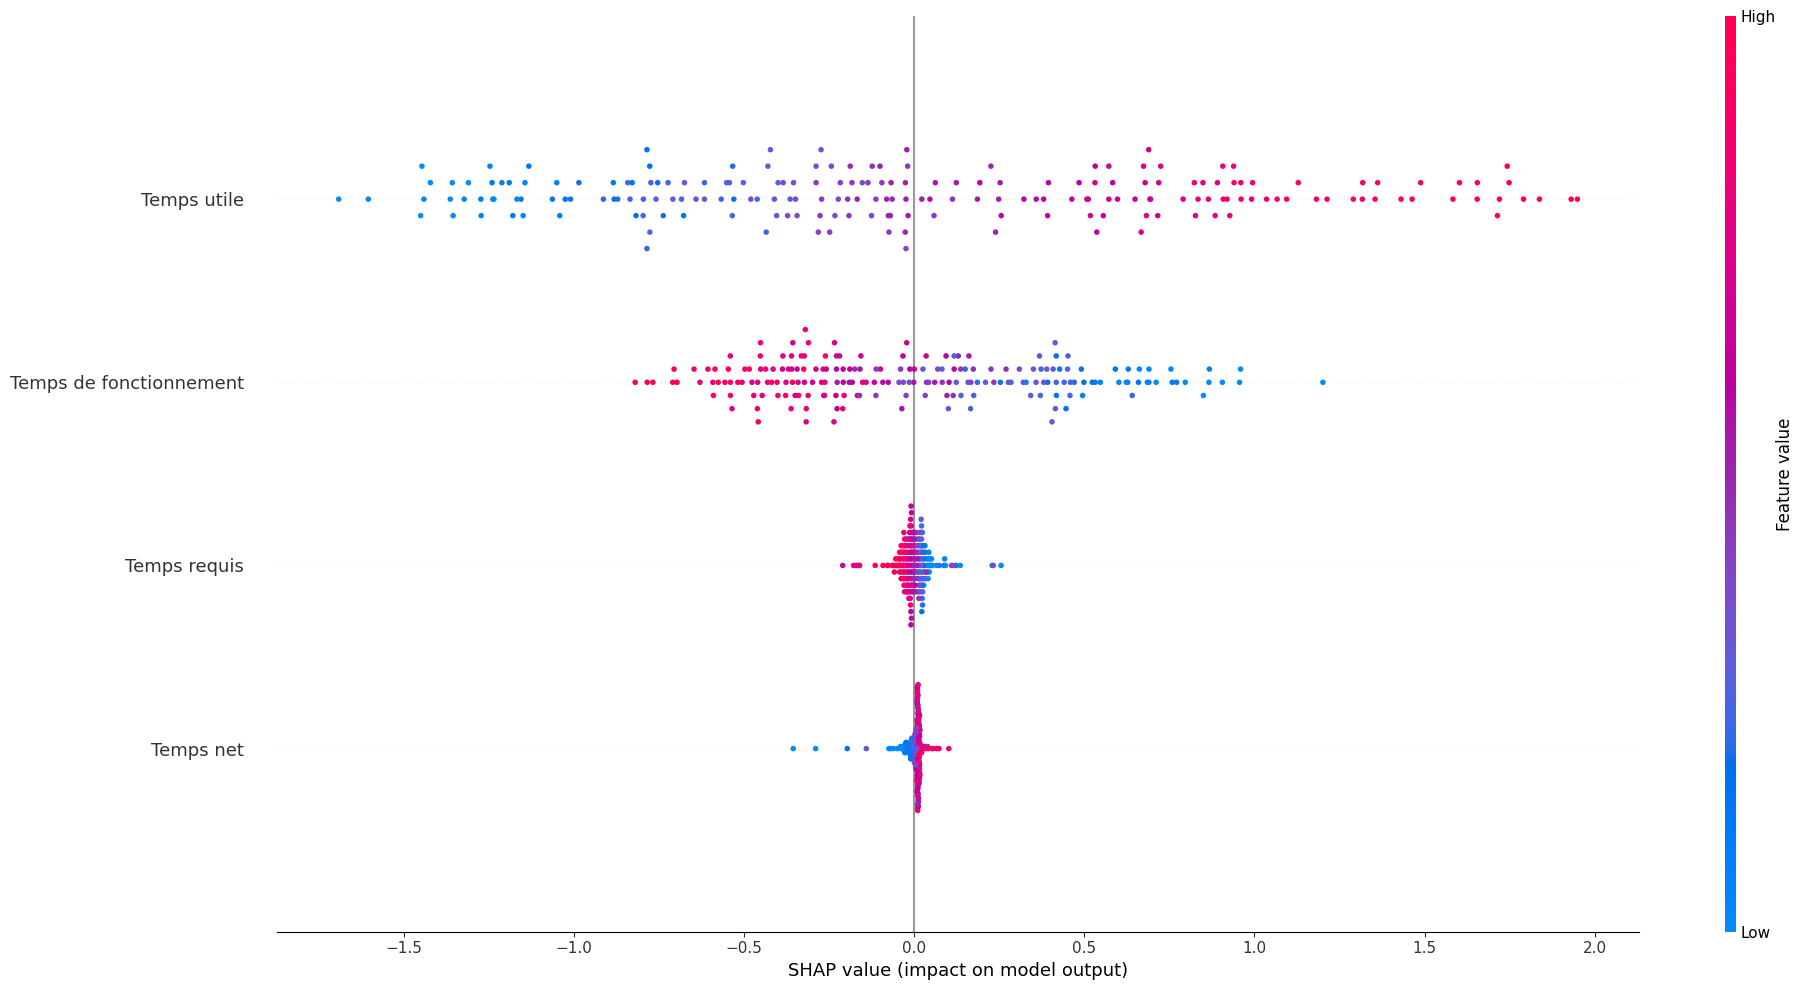

In [31]:
torch.set_grad_enabled(False)

def f(x):
    prediction_proba = clf_model(Variable(torch.from_numpy(x))).detach().numpy()
    __, prediction = torch.max(torch.tensor(prediction_proba), 1)
    return prediction.numpy()

data = x_test.numpy()

explainer = shap.KernelExplainer(f, data)
shap_values = explainer.shap_values(data)

shap.initjs()

shap.summary_plot(shap_values, data, feature_names=["Temps de fonctionnement", "Temps requis", "Temps net", "Temps utile"], plot_size=(20, 10))

In [32]:
shap.plots.force(explainer.expected_value, shap_values)

### Étape 5 : Plan d'action

Depuis SHAP, nous pouvons voir que les features impactent equilibréement la classification des machines, mais le temps de fonctionnement et le temps utile ont le pouvoir prédictif le plus élevé.

Pour améliorer la performance des machines, nous devons nous concentrer sur l'augmentation du temps de fonctionnement et du temps utile. Cela peut être fait en réduisant le temps d'arrêt planifié et duree de panne, et en augmentant la cadence de production.